# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


# Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка данных

### Импортирование необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
tqdm.pandas()

### Загрузка данных

In [ ]:
df = pd.read_csv("https://code.s3.yandex.net/datasets/toxic_comments.csv")

### Анализ данных

In [ ]:
pd.set_option('display.max_colwidth', 0)
warnings.filterwarnings("ignore")

In [ ]:
df.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.101679,0.302226,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Соотношение токсичных и нормальных комментариев:
0    0.898321
1    0.101679
Name: toxic, dtype: float64


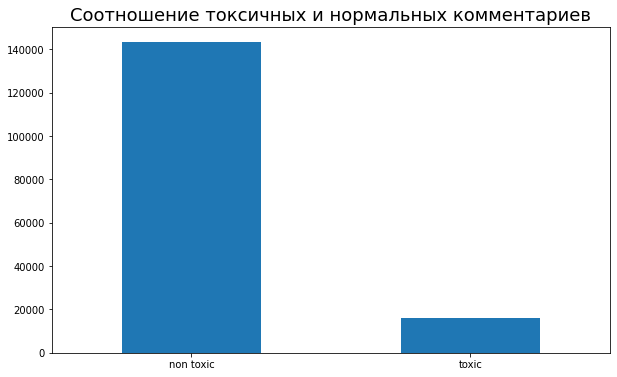

In [ ]:
print('Соотношение токсичных и нормальных комментариев:')
print(df['toxic'].value_counts(normalize=True))

df['toxic'].value_counts().plot(kind="bar", figsize=(10, 6))
plt.title('Соотношение токсичных и нормальных комментариев', fontsize=18)
plt.xticks(ticks=df['toxic'].value_counts(normalize=True).index, labels=['non toxic', 'toxic'], rotation=0)
plt.show()

Наблюдается сильный дисбаланс целевого признака, в 9 раз.

### Предобработка данных

Для дальнейшей работы с данными нужно будет провести несколько операций над ними, а именно:

- Избавление от лишнего в тексте
- Разбитие текстов на слова
- Избавление от *стоп слов*
- Проведение лемматизации

Для этапов будут созданы отдельные функции, которые на последнем этапе будут применены к столбцу ***text***.

In [ ]:
def clean_and_split_text(text):
    return re.sub(r'[^a-zA-Z ]', ' ', text.lower()).split()

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    return [lemmatizer.lemmatize(word) for word in text]

In [ ]:
df['lemmatize_text'] = df['text'].progress_apply(lambda x: lemmatize(clean_and_split_text(x)))
df.head()

100%|██████████| 159571/159571 [00:32<00:00, 4847.81it/s]


,text,toxic,lemmatize_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, reverted, they, weren, t, vandalism, just, closure, on, some, gas, after, i, voted, at, new, york, doll, fac, and, please, don, t, remove, the, template, from, the, talk, page, since, i, m, retired, now]"
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,"[d, aww, he, match, this, background, colour, i, m, seemingly, stuck, with, thanks, talk, january, utc]"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,"[hey, man, i, m, really, not, trying, to, edit, war, it, s, just, that, this, guy, is, constantly, removing, relevant, information, and, talking, to, me, through, edits, instead, of, my, talk, page, he, seems, to, care, more, about, the, formatting, than, the, actual, info]"
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,"[more, i, can, t, make, any, real, suggestion, on, improvement, i, wondered, if, the, section, statistic, should, be, later, on, or, a, subsection, of, type, of, accident, i, think, the, reference, may, need, tidying, so, that, they, are, all, in, the, exact, same, format, ie, date, format, etc, i, can, do, that, later, on, if, no, one, else, doe, first, if, you, have, any, preference, for, formatting, style, on, reference, or, want, to, do, it, yourself, please, let, me, know, there, appears, to, be, a, backlog, on, article, for, review, so, i, guess, there, may, be, a, delay, until, a, ...]"
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,"[you, sir, are, my, hero, any, chance, you, remember, what, page, that, s, on]"


### Вывод

В данных наблюдается сильный дисбаланс целевого признака, в 9 раз, нужно будет учесть этот факт при обучении моделей.

В ходе предобработки данных были выполнены: избавление от лишнего в тексте, разбитие текстов на слова, избавление от стоп слов и была проведена лемматизация.

## Обучение

### Выделение признаков и разбиение данных

In [ ]:
features = df['lemmatize_text']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.20, random_state=244466666)
print('Количество элементов обучающей выборки: {:.0f}%'.format(features_train.shape[0]/df.shape[0] * 100))
print('Количество элементов тестовой выборки: {:.0f}%'.format(features_test.shape[0]/df.shape[0] * 100))

Количество элементов обучающей выборки: 80%
Количество элементов тестовой выборки: 20%


In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
features_train_tf = count_tf_idf.fit_transform(features_train)
features_test_tf = count_tf_idf.transform(features_test)

In [ ]:
print('Размер обучающей выборки:', features_train_tf.shape)
print('Размер тестовой выборки:', features_test_tf.shape)

Размер обучающей выборки: (127656, 139385)
Размер тестовой выборки: (31915, 139385)


***Для решения задачи будем использовать следующие модели:***

- Логистическая регрессия
- Дерево решений
- Случайный лес
- Метод опорных векторов

### LogisticRegression 

#### LogisticRegression без баланса классов

In [ ]:
lr_model = LogisticRegression(random_state = 244466666)

In [ ]:
# print('F1 score на тренирочной выборке:',(cross_val_score(lr_model, features_train_tf, target_train, cv=3, scoring='f1')).mean())

F1 score на тренирочной выборке: 0.7030107215831563

**Тестирование**

In [ ]:
# lr_model.fit(features_train_tf, target_train)
# lr_predicted = lr_model.predict(features_test_tf)
# f1_score(target_test, lr_predicted)

0.7344444444444445

#### LogisticRegression с балансом классов

In [ ]:
lr_balanced_model = LogisticRegression(class_weight='balanced',random_state = 244466666)

In [ ]:
# print('F1 score на тренирочной выборке c учетом баланса классов:',(cross_val_score(lr_balanced_model, features_train_tf, target_train, cv=3, scoring='f1')).mean())

F1 score на тренирочной выборке c учетом баланса классов: 0.7482495836409196

**Тестирование**

In [ ]:
# lr_balanced_model.fit(features_train_tf, target_train)
# lr_balanced_predicted = lr_balanced_model.predict(features_test_tf)
# f1_score(target_test, lr_balanced_predicted)

0.7454839579401455

### DecisionTreeClassifier 

#### DecisionTreeClassifier без баланса классов

In [ ]:
dt_model = DecisionTreeClassifier(random_state=244466666)

In [ ]:
# print('F1 score на тренирочной выборке:',(cross_val_score(dt_model, features_train_tf, target_train, cv=3, scoring='f1')).mean())

F1 score на тренирочной выборке: 0.7063639346836851

**Тестирование**

In [ ]:
# dt_model.fit(features_train_tf, target_train)
# dt_predicted = dt_model.predict(features_test_tf)
# f1_score(target_test, dt_predicted)

0.7118218877391033

#### DecisionTreeClassifier с балансом классов

In [ ]:
dt_balanced_model = DecisionTreeClassifier(random_state=244466666, class_weight='balanced')

In [ ]:
# print('F1 score на тренирочной выборке c учетом баланса классов:',(cross_val_score(dt_balanced_model, features_train_tf, target_train, cv=3, scoring='f1')).mean())

F1 score на тренирочной выборке c учетом баланса классов: 0.6413581536828953

**Тестирование**

In [ ]:
# dt_balanced_model.fit(features_train_tf, target_train)
# dt_balanced_predicted = dt_balanced_model.predict(features_test_tf)
# f1_score(target_test, dt_balanced_predicted)

0.6448637316561844

### RandomForestClassifier

#### RandomForestClassifier без баланса классов

In [ ]:
rf_model = RandomForestClassifier(random_state=244466666)

In [ ]:
# print('F1 score на тренирочной выборке:',(cross_val_score(rf_model, features_train_tf, target_train, cv=3, scoring='f1')).mean())

F1 score на тренирочной выборке: 0.6786194807503619

**Тестирование**

In [ ]:
# rf_model.fit(features_train_tf, target_train)
# rf_predicted = rf_model.predict(features_test_tf)
# f1_score(target_test, rf_predicted)

0.7048961706991806

#### RandomForestClassifier с балансом классов

In [ ]:
rf_balanced_model = RandomForestClassifier(random_state=244466666, class_weight='balanced')

In [ ]:
# print('F1 score на тренирочной выборке c учетом баланса классов:',(cross_val_score(rf_balanced_model, features_train_tf, target_train, cv=3, scoring='f1')).mean())

F1 score на тренирочной выборке c учетом баланса классов: 0.6198031005107292

**Тестирование**

In [ ]:
# rf_balanced_model.fit(features_train_tf, target_train)
# rf_balanced_predicted = rf_balanced_model.predict(features_test_tf)
# f1_score(target_test, rf_balanced_predicted)

0.6329268292682926

### LinearSVC

#### LinearSVC без баланса классов

In [ ]:
LSVM_model = LinearSVC(random_state = 244466666)

In [ ]:
# print('F1 score на тренирочной выборке:',(cross_val_score(LSVM_model, features_train_tf, target_train, cv=3, scoring='f1')).mean())

F1 score на тренирочной выборке: 0.7655599262765532

**Тестирование**

In [ ]:
# LSVM_model.fit(features_train_tf, target_train)
# LSVM_predicted = LSVM_model.predict(features_test_tf)
# f1_score(target_test, LSVM_predicted)

0.775628957727195

#### LinearSVC c балансом классов

In [ ]:
LSVM_balanced_model = LinearSVC(random_state = 244466666,class_weight='balanced')

In [ ]:
# print('F1 score на тренирочной выборке c учетом баланса классов:',(cross_val_score(LSVM_balanced_model, features_train_tf, target_train, cv=3, scoring='f1')).mean())

F1 score на тренирочной выборке c учетом баланса классов: 0.7570375740462548

**Тестирование**

In [ ]:
# LSVM_balanced_model.fit(features_train_tf, target_train)
# LSVM_balanced_predicted = LSVM_balanced_model.predict(features_test_tf)
# f1_score(target_test, LSVM_balanced_predicted)

0.7520954681062649

## Выводы

Целью данной работы было получить модель, классифицирующую комментарии. Для классификации были выбраны модели логистической регрессии, дерева решений, случайного леса и метода опорных векторов. Результаты оценивались метрикой f1, в результате тестирования на тренирочной выборке ошибка двух моделей оказалась лучше или очень близка к требуемой заказчиком - это модели логистической регрессии и LinearSVC c балансом классов.

Лучшей моделью на тестовой выборке оказалась LinearSVC модель. Полученный результат f1 равен 0.75209. Результаты исследований можно применять для дальнейшей разработки модели и внедрения в бизнес процесс.